<div style="background-color:#e6ffe6; padding:10px; color:black; border-style:
solid;; border-color:#00e600; border-width:1px">

# AST4310 2025, Project 3

</div>

In [1]:
using CairoMakie
using FastGaussQuadrature 
using LinearAlgebra
using Unitful
using JLD2
import SpecialFunctions: erfcx
import PhysicalConstants.CODATA2018: e, m_e, h, k_B, c_0

# Background

In this project you will go beyond simple LTE calculations, and perform numerical computations including scattering (non-LTE for a two-level atom), and compute polarised line profiles in the presence of a magnetic field.

## 1. Non-LTE Radiative Transfer

### 1.1 The Feautrier method

The Feautrier method is a numerical scheme to solve the radiative transfer equation for the angle-averaged intensity $J_\nu$. By itself, it does not solve the problem in non-LTE. Instead, it solves the radiative transfer equation for a known source function and extinction. Given a source function, the Feautrier method returns the $P_\nu$ quantity, from which $J_\nu$ can be reconstructed:

$$
P_\nu(\tau_\nu, \mu) \equiv \frac{1}{2}\left[I_\nu(\tau_\nu, \mu) + I_\nu(\tau_\nu, -\mu)\right] = \frac{1}{2}\left[I^+ + I^-\right].
$$
From $P_\nu$ we can obtain $J_\nu$:

$$
\begin{aligned}
J_\nu(\tau_i) &= \int_0^{+1} P_\nu(\tau_i, \mu)d\mu \\ 
 &= \sum_{j=1}^m a_j P(\tau_i, \mu_j).
\end{aligned}
$$ 

In matrix form, you can write the step to get $P_\nu$ by solving the equation

\begin{equation}
\mathbf{T}P = S,
\end{equation}

where $\mathbf{T}$ is a tridiagonal matrix. The function `Tmatrix` provided below computes $\mathbf{T}$ for a single frequency and direction on a 1D plane-parallel atmosphere, given an optical depth scale and $\mu$:

In [2]:
"""
Computes the T matrix using Feautrier's method for a 1D plane-parallel atmosphere.
"""
function Tmatrix(tau, μ)
    ndep = length(tau)
    τ = tau / μ
    A = zeros(Float64, ndep)
    B = zeros(Float64, ndep)
    C = zeros(Float64, ndep)

    # Boundary conditions top
    Δτ = τ[2] - τ[1]
    B[1] = 2 / Δτ^2 + 2 / Δτ + 1
    C[1] = 2 / Δτ^2
    # Boundary conditions bottom
    Δτ = τ[end] - τ[end-1]
    A[end] = 2 / (Δτ * (Δτ + 2))
    B[end] = (2 + 2*Δτ + Δτ^2) / (Δτ * (Δτ + 2))

    for i in 2:ndep-1
        Δτ = τ[i+1] - τ[i]
        Δτm = τ[i] - τ[i-1]
        A[i] = 2 / (Δτm * (Δτm + Δτ))
        B[i] = 1 + 2 / (Δτ * Δτm)
        C[i] = 2 / (Δτ * (Δτm + Δτ))
    end

    return Tridiagonal(-A[2:end], B, -C[1:end-1])
end

Tmatrix

Also useful is the function to compute the angle quadratures:

In [3]:
"""
Returns the nodes and weights form a Gaussian
quadrature with k points. Rescaled to an interval
from [0, 1].
"""
function quadrature(;k=5)
    nodes, weights = gausslegendre(k)
    return nodes/2 .+ 0.5, weights/2
end

quadrature

Given a $\mathbf{T}$ matrix, to solve the system for $P$ and then $J$ we can use different approaches. The direct method involves building the $\mathbf{\Lambda}$ explicitly (via matrix inversion of $\mathbf{T}$) and then using $\mathbf{\Lambda}$ to obtain $J$:

$$
\begin{aligned}
\mathbb{1}\vec{P_\mu} &= \mathbf{T}^{-1}_\mu \vec{S}\\
\mathbf{\Lambda} &= \sum_\mu a_\mu \mathbf{T}^{-1}_\mu \\
\vec{J} &= \mathbf{\Lambda} \vec{S}.
\end{aligned}
$$

This can be coded in the function:

In [4]:
function Λ_matrix(τ)
    n = length(τ)
    Λ = zeros(eltype(τ), n, n)
    for (μ, w) in zip(quadrature()...)
        T = Tmatrix(τ, μ)
        Λ .+= w * inv(T)
    end
    return Λ
end

Λ_matrix (generic function with 1 method)

An alternative way, which still involves inverting a matrix, but saves computational resources to avoid building a $\mathbf{\Lambda}$ matrix explictly, is to take advantage of the fact that $\mathbf{T}$ is not a dense matrix (but a sparse tridiagonal matrix). Then we can use specialised algorithms that can invert it much faster and implicitly solve the system for $J$ (Julia's `LinearAlgebra` package does this automatically when the matrix type is `Tridiagonal`):

In [5]:
function solve_Λ_implicit(τ, S)
    J = zeros(eltype(S), length(τ))
    for (μ, w) in zip(quadrature()...)
        T = Tmatrix(τ, μ)
        P = T \ S
        J .+= w * P
    end
    return J
end

solve_Λ_implicit (generic function with 1 method)

### 1.2 Radiative Transfer with coherent scattering in a 2-level atom

Scattering involves radiation that is non-local, and for the case of coherent scattering (no change in frequency after a collision), and a medium composed of atoms with only two levels, we can express it as a change in the source function. Instead of following only the local conditions (the thermal part via the Planck function $B_\nu$), the source function can now be written as a scattering part plus a thermal part, where the balance is controlled by the photon destruction probability $\varepsilon_\nu$:

$$
\begin{aligned}
S_\nu &= (1-\varepsilon_\nu) J_\nu + \varepsilon_\nu B_\nu \\
S_\nu &= (1-\varepsilon_\nu) \mathbf{\Lambda}_\nu[S_\nu] + \varepsilon_\nu B_\nu \\
\end{aligned}
$$

If we have the $\mathbf{\Lambda}_\nu$ operator in matrix form, and can invert it, we can solve this system for $S_\nu$:
$$
S_\nu = (\mathbb{1}-(1-\varepsilon_\nu)\mathbf{\Lambda}_\nu)^{-1}[\varepsilon_\nu B_\nu].
$$
This direct solution can be coded as follows:

In [6]:
"""
Solve a coherent scattering problem with direct solver.
"""
function solve_cs_direct(τ, B, ε)
    n = length(τ)
    Λ = Λ_matrix(τ)
    M = inv(I - (1 - ε) .* Λ)
    S = ε * M * B
    J = Λ * S
    return S, J
end

solve_cs_direct

### 1.3 $\Lambda$ iteration

Because of the matrix inversions, and building $\mathbf{\Lambda}$ explicitly, the direct solution is never feasible for realistic computations. Instead, the problem is solved iteratively using a starting guess for $S_\nu$, because often it is possible to compute $J_\nu$ from $S_\nu$ without explicitly building $\mathbf{\Lambda}$ (see example above with the Feautrier method).

The simplest way to solve the system by iteration is the classical $\Lambda$ iteration:

\begin{equation}
S^{(n+1)} = (1-\varepsilon)\mathbf{\Lambda}[S^{(n)}] + \varepsilon B,
\end{equation}

where we need a guess for $S^{(1)}$, often $S^{(1)}=B.$ For the iterative schemes, we can measure the convergence speed by calculating the fractional difference between source functions of successive iterations, e.g.:
\begin{equation}
\delta = \left|\left|\frac{S_\nu^{(n+1)}-S_\nu^{(n)}}{S_\nu^{(n)}}\right| \right|.
\end{equation}

We typically stop the iteration when $\delta\approx 10^{-3}$.

An alternative that can be much more efficient is the approximate (or accelerated) $\Lambda$ iteration (ALI):

\begin{equation}
S^{(n+1)} = (\mathbb{1}-(1-\varepsilon)\mathbf{\Lambda}^*)^{-1}\left[S^\mathrm{FS}-(1-\varepsilon)\mathbf{\Lambda}^*[S^{(n)}]\right],
\end{equation}

where $S^\mathrm{FS}$ is the source function from a formal solution: $S=(1-\varepsilon)J + \varepsilon B$, when you have calculated $J$ implicitly without building $\mathbf{\Lambda}$ (e.g. as above with `solve_Λ_implicit`).

ALI involves building an approximate $\mathbf{\Lambda}^*$ that is easier to construct. The example we will use here is the OAB, or diagonal operator, which is the diagonal of the full $\mathbf{\Lambda}$ operator. But how to obtain the diagonal of a matrix without actually building the matrix in the first place? If you consider the Feautrier method, the full $\mathbf{\Lambda}$ is obtained by the sum over $\mu$ of the inverses of $\mathbf{T}_\mu$ matrices, which are tridiagonal (the inverse of a tridiagonal matrix is NOT tridiagonal). So the diagonal of $\mathbf{\Lambda}$ is the sum of the diagonals of the inverses of tridiagonal matrices. And fortunately there are algorithms to obtain the diagonal from an inverse tridiagonal matrix that do not involve building the full matrix. Here is an example:

In [7]:
"""
Algorithm of Usmani 1994, Computers Math. Applic. 27, 8, 59-66.
Reaches the limit of double precision for N~600,
use BigFloat for larger numbers.

The input is a tridiagonal matrix.
"""
function diag_inverse_tri(B)
    n = size(B)[1]
    a = diag(B, 1)
    b = diag(B)
    c = diag(B, -1)
    θ = zeros(eltype(B), n+2)
    ϕ = zeros(eltype(B), n+4)
    dia = zeros(eltype(B), n)

    θ[1] = 1
    θ[2] = b[1]
    for i in 3:n+1
        θ[i] = b[i-1] * θ[i-1] - a[i-2] * c[i-2] * θ[i-2]
    end

    ϕ[n+2] = 1
    ϕ[n+1] = b[n]
    for i in n:-1:3
        ϕ[i] = b[i-1] * ϕ[i+1] - a[i-1] * c[i-1] * ϕ[i+2]    
    end

    for i in 1:n
        dia[i] = θ[i] * ϕ[i+2] / θ[n+1]
    end
    return dia
end

diag_inverse_tri


## 2. Zeeman Effect and Polarisation

### 2.1 Zeeman Effect

The Zeeman effect is the splitting of magnetic levels due to an external magnetic field. The strength and pattern of the splitting depend on the electronic configuration of the upper and lower levels. For any splitting to occur, the total angular momentum quantum number $J$ needs to be larger than zero. The splitting of a given level occurs for different values of the secondary total angular momentum quantum number $M_j$ (the projections of $J$ over an arbitrary z axis): $M_j = -J, \cdots, J$, so there are $2J + 1$ splits on a given level. Any transitions need to obey the electric dipole selection rule of $\Delta M_j = 0, \pm1$. The amount of splitting in energy is given by:

$$
\Delta E_B = \mu_B B (g^uM_j^u-g^lM_j^l),
$$
where $B\equiv\lVert\vec{B}\rVert$, $\mu_B$ is Bohr's magneton:

$$
\mu_B \equiv \frac{e\hbar}{2m_e},
$$
and $g^u$ and $g^l$ are the Landé factors for the upper and lower levels, for LS coupling given by:

$$
g = 1 + \frac{1}{2}\frac{J(J+1) + S(S+1) - L(L+1)}{J(J+1)}.
$$
For $J=0$, $g=1$.

In wavelength, the Zeeman splitting is given by:

$$
\lambda = \lambda_0 - \Delta\lambda_B (g^uM_j^u-g^lM_j^l),
$$
where $\lambda_0$ is the transition wavelength and 

$$
\Delta\lambda_B = \frac{e}{4\pi m_e c}\lambda_0^2 B.
$$

When $S=0$ or $g^u=g^l$, we have only three Zeeman components, a regime called normal Zeeman effect. These components correspond to the three scenarios of the selection rule $\Delta M_j = 0, \pm1$, and are called $\pi$ ($\Delta M_j=0$), $\sigma_r$ ($\Delta M_j=+1$), and $\sigma_b$ ($\Delta M_j=-1$). For other situations, we have the so-called anomalous Zeeman effect. For transitions with a complex splitting pattern, the effective Landé factor $\bar{g}$ is a useful concept. It measures the distance between $\lambda_0$ and "centre of gravity" of the $\sigma$ components, and is defined as:


$$
\begin{aligned}
\bar{g} &= \frac{1}{2}(g_1+g_2) + \frac{1}{4}(g_1 - g_2)d\\
d &= J_1(J_1+1)-J_2(J_2+1).
\end{aligned}
$$

In the anomalous Zeeman effect, not all components have the same strength. This strength is often called $S_q^{J^l J^u}$, is dependent on $q=\Delta M_j$, and $J$ for the upper and lower levels. The $S_q^{J^l J^u}$ are tabulated in [de la Cruz Rodriguez & van Noort (2017, Table 1, page 116)](https://ui.adsabs.harvard.edu/abs/2017SSRv..210..109D/abstract), and are coded in the function `zeeman_strength()` below. 

Each Zeeman component gives rise to one line profile. These are often called $\phi_-$, $\phi_0$, and $\phi_+$, respectively for $\Delta M_j=-1, 0, 1$, and can be written, for the normal Zeeman effect (assuming no macroscopic velocities):

$$
\begin{aligned}
\phi_0 &= H\left(a, v\right)\\
\phi_\pm &= H\left(a, v \mp \bar{g}\frac{\Delta\lambda_B}{\Delta\lambda_D} \right),
\end{aligned}
$$

Where $H(a, v)$ is the Voigt profile, and $\Delta\lambda_D$ the Doppler broadening. In the case of more than three components, one needs to sum over all the allowed transitions (for values of $M_j^u$ and $M_j^l$) and weigh the profiles by the Zeeman strength:

$$
\phi_q = \sum_{u, l} S_q^{J^l J^u} H\left(a, v + \left[g^uM_j^u-g^lM_j^l\right]\frac{\Delta\lambda_B}{\Delta\lambda_D} \right),
$$
where $q\equiv\Delta M_j=-1, 0, 1$.

Here are some of the expressions above coded into functions, for your convenience:



In [8]:
"""
Calculates Landé factor from LS coupling.
"""
function g_LS(L, S, J)
    if J == 0
        return 1.
    else 
        return 1 + 0.5 * (J * (J + 1) + S * (S + 1) - L * (L + 1)) / (J * (J + 1))
    end
end


"""
Calculates the effective Landé factor.
"""
function g_eff(g1, g2, J1, J2)
    d = J1 * (J1 + 1) - J2 * (J2 + 1)
    return 0.5 * (g1 + g2) + 0.25 * (g1 - g2) * d
end


"""
Calculates strengths of Zeeman components.
"""
function zeeman_strength(J_l, J_u, M_l, M_u)
    J = J_l
    M = M_l
    ΔM = M_u - M_l
    ΔJ = J_u - J_l
    if ΔM == 1
        if ΔJ == 1
            return (3 * (J + M + 1) * (J + M + 2)) / (2 * (J + 1) * (2J + 1) * (2J + 3))
        elseif ΔJ == 0
            return (3 * (J - M) * (J + M + 1)) / (2 * J * (J + 1) * (2J + 1))
        elseif ΔJ == -1
            return (3 * (J - M) * (J - M - 1)) / (2 * J * (2J - 1) * (2J + 1))
        else
            throw(ArgumentError("Invalid transition: ΔJ must be -1, 0, or 1"))
        end
    elseif ΔM == 0
        if ΔJ == 1
            return (3 * (J - M + 1) * (J + M + 1)) / ((J + 1) * (2J + 1) * (2J + 3))
        elseif ΔJ == 0
            return 3 * M^2 / (J * (J + 1) * (2J + 1))
        elseif ΔJ == -1
            return (3 * (J - M) * (J + M)) / (J * (2J - 1) * (2J + 1))
        else
            throw(ArgumentError("Invalid transition: ΔJ must be -1, 0, or 1"))
        end
    elseif ΔM == -1
        if ΔJ == 1
            return (3 * (J - M + 1) * (J - M + 2)) / (2 * (J + 1) * (2J + 1) * (2J + 3))
        elseif ΔJ == 0
            return (3 * (J + M) * (J - M + 1)) / (2 * J * (J + 1) * (2J + 1))
        elseif ΔJ == -1
            return (3 * (J + M) * (J + M - 1)) / (2 * J * (2J - 1) * (2J + 1))
        else
            throw(ArgumentError("Invalid transition: ΔJ must be -1, 0, or 1"))
        end
    else
        throw(ArgumentError("Invalid transition: ΔM must be -1, 0, or 1"))
    end
end

zeeman_strength

### 2.2 Polarised Radiative Transfer Equation

For the polarised case, the radiative transfer equation (RTE) becomes a vector equation, where we no longer solve just for intensity $I_\nu$, but for the Stokes vector $\vec{I_\nu}$:

$$
\vec{I_\nu} = 
\begin{pmatrix}
I_\nu \\
Q_\nu \\
U_\nu \\
V_\nu 
\end{pmatrix}.
$$

The RTE then becomes:
$$
\frac{\mathrm{d}\vec{I_\nu}}{\mathrm{d}s} = \vec{j_\nu} - \mathbf{A}_\nu\vec{I_\nu},
$$

where $\mathbf{A}_\nu$ is the absorption matrix and $\vec{j_\nu}$ the emissivity vector. In the case where there is no continuum emission of polarised radiation (true in most stars), we can simplify $\mathbf{A}_\nu$:

$$
\begin{aligned}
\mathbf{A}_\nu &= \alpha_\nu^c \mathbb{1} + \mathbf{A}_\nu^l \\
\mathbf{A}_\nu &= \alpha_\nu^c \mathbb{1} + \alpha_\nu^l \mathbf{\Phi}_\nu,
\end{aligned}
$$

where $\alpha_\nu^c$ is the continuous extinction coefficient and $\alpha_\nu^l$ is the line extinction coefficient  ***without the line profile part*** $H(a, v)$. The radiative transfer equation can then be further simplified by dividing by $\alpha_\nu^c$ and using $\eta_\nu\equiv\alpha_\nu^l / \alpha_\nu^c$:


$$
\frac{\mathrm{d}}{\mathrm{d}\tau_\nu^c}
\begin{pmatrix}
I_\nu \\
Q_\nu \\
U_\nu \\
V_\nu 
\end{pmatrix} = 
\vec{S_\nu} - (\mathbb{1} + \eta_\nu \mathbf{\Phi}_\nu) 
\begin{pmatrix}
I_\nu \\
Q_\nu \\
U_\nu \\
V_\nu 
\end{pmatrix}.
$$





The line profile information goes into the matrix $\mathbf{\Phi}$, which in general can be written as:

$$
\mathbf{\Phi} = 
\begin{pmatrix}
\phi_I & \phi_Q & \phi_U & \phi_V \\
\phi_Q & \phi_I & \psi_V & -\psi_U \\
\phi_U & -\psi_V & \phi_I & \psi_Q \\
\phi_V & \psi_U & -\psi_Q & \phi_I 
\end{pmatrix}. 
$$

This matrix has 7 independent terms, and can be divided into three parts:


$$
\mathbf{\Phi}  = 
\begin{pmatrix}
\phi_I & 0 & 0 & 0 \\
0 & \phi_I & 0 & 0 \\
0 & 0 & \phi_I & 0 \\
0 & 0 & 0 & \phi_I 
\end{pmatrix} +
%
\begin{pmatrix}
0 & \phi_Q & \phi_U & \phi_V \\
\phi_Q & 0 & 0 & 0 \\
\phi_U & 0 & 0 & 0 \\
\phi_V & 0 & 0 & 0 
\end{pmatrix} +
%
\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & \psi_V & -\psi_U \\
0 & -\psi_V & 0 & \psi_Q \\
0 & \psi_U & -\psi_Q & 0 
\end{pmatrix}.
$$

The first term represents absorption of energy, the second term represents dichroism, and the last term represents magneto-optical effects.

Under Zeeman effect, for a magnetic field with inclination angle $\gamma$ and azimuthal angle $\chi$, the $\phi$ profiles are given by:

$$
\begin{aligned}
\phi_I &= \phi_\Delta\sin^2\gamma + \frac{1}{2}(\phi_+ + \phi_-) \\
\phi_Q &= \phi_\Delta\sin^2\gamma \cos 2\chi \\
\phi_U &= \phi_\Delta\sin^2\gamma \sin 2\chi \\
\phi_V &= \frac{1}{2}(\phi_+ - \phi_-) \cos \gamma \\
\phi_\Delta &= \frac{1}{2} \left[ \phi_0 + \frac{1}{2}(\phi_+ + \phi_-)\right],
\end{aligned}
$$

where $\phi_-$, $\phi_0$, and $\phi_+$ are the line profiles for the Zeeman components defined in section 2.1. The $\psi$ profiles, for the magneto-optical effects, are defined similarly:

$$
\begin{aligned}
\psi_I &= \psi_\Delta\sin^2\gamma + \frac{1}{2}(\psi_+ + \psi_-) \\
\psi_Q &= \psi_\Delta\sin^2\gamma \cos 2\chi \\
\psi_U &= \psi_\Delta\sin^2\gamma \sin 2\chi \\
\psi_V &= \frac{1}{2}(\psi_+ - \psi_-) \cos \gamma \\
\psi_\Delta &= \frac{1}{2} \left[ \psi_0 + \frac{1}{2}(\psi_+ + \psi_-)\right],
\end{aligned}
$$

where the $\psi_-$, $\psi_0$, and $\psi_+$ are defined very similarly to the $\phi$ counterparts. E.g. in the case of normal Zeeman effect:

$$
\begin{aligned}
\psi_0 &= L(a, v)\\
\psi_\pm &= L\left(a, v \mp \bar{g}\frac{\Delta\lambda_B}{\Delta\lambda_D} \right).
\end{aligned}
$$

And for anomalous Zeeman effect:

$$
\psi_q = \sum_{u, l} S_q^{J^l J^u} L\left(a, v + \left[g^uM_j^u-g^lM_j^l\right]\frac{\Delta\lambda_B}{\Delta\lambda_D} \right).
$$

The only change is from the Voigt profile $H(a, v)$ to the Dispersion function (sometimes called Faraday profile) $L(a, v)$. The two functions are related, as they are respectively the real and imaginary parts of the [Fadeeva function](https://en.wikipedia.org/wiki/Faddeeva_function):

$$
\mathcal{H}(a, v) = H(a, v) + iL(a, v).
$$

In Julia, both functions can be computed via `erfcx`:

In [1]:
voigt(a, u) = real(erfcx(a - u*im)) / sqrt(π)
faraday(a, u) = imag(erfcx(a - u*im)) / sqrt(π)

faraday (generic function with 1 method)

### 2.3 The Unno-Rachkovsky Solution

A simplified solution for the polarised RTE is the Unno-Rachkovsky solution. In this solution, one uses the simplifying assumption that the source function (in LTE, $B_\nu$) varies linearly with the continuum optical depth:

$$
S_\nu = S_0 + S_1\tau_c.
$$

An atmosphere that fulfils the above is called a *Milne-Eddington* atmosphere. Moreover, to greatly simplify the polarised RTE, this solution assumes that everything that affects the absorption matrix $\mathbf{A}_\nu$ is constant with height:

* Magnetic field vector: $B$, $\gamma$, $\chi$
* Ratio of extinctions: $\eta_\nu$
* Broadening of the line: $a$ and $\Delta\lambda_D$.

When the above are fulfilled, there is an exact solution to the polarised RTE, and it can be written explicitly (dropping the frequency indices) as:

$$
\begin{aligned}
I &= S_0 + \Delta^{-1}\left[k_I(k_I^2+ f_Q^2+f_U^2+f_V^2)\right]S_1 \\
Q &= -\Delta^{-1} \left[k_I^2 k_Q + k_I(k_V f_U- k_U f_V) + f_Q\Pi\right] S_1 \\
U &= -\Delta^{-1} \left[k_I^2 k_U + k_I(k_Q f_V- k_V f_Q) + f_U\Pi\right] S_1 \\
V &= -\Delta^{-1} \left[k_I^2 k_V + f_V\Pi\right] S_1,
\end{aligned}
$$

where 
$$
\begin{aligned}
\Delta & = k_I^2(k_I^2 - k_Q^2-k_U^2-k_V^2 + f_Q^2+f_U^2+f_V^2) + \Pi^2 \\
\Pi &= k_Q f_Q + k_U f_U + k_V f_V,
\end{aligned}
$$

and
$$
\begin{aligned}
k_I  =  1 + \eta_\nu \phi_I, \;\; k_Q&=\eta_\nu \phi_Q, \;\;   k_U = \eta_\nu \phi_U, \;\;   k_V = \eta_\nu \phi_V\\
  f_Q &= \eta_\nu \psi_Q, \;\;  f_U = \eta_\nu \psi_U, \;\; f_V = \eta_\nu \psi_V.
\end{aligned}
$$

Below you can find an implementation of the Unno-Rachkovsky solution in python. The arguments of this function are the free parameters for the above: $\gamma$, $\chi$, $\eta_\nu$, $a$, and $\Delta\lambda_B / \Delta\lambda_D$. While this last ratio can just be given as a ratio, for detailed calculations one needs to compute explicitly $\Delta\lambda_B$ for a given value of the magnetic field strength. This function only works for the normal Zeeman effect, but modification for arbitrary Zeeman patterns is just a matter of changing $\phi_{0}$, $\phi_\pm$, $\psi_{0}$, and $\psi_\pm$ to the appropriate expressions summing over components.

In [10]:
function unno_rachkovsky(
    u;
    s0 = 1,
    s1 = 5,
    η = 20,
    a = 0.05,
    g_eff = 1,
    delta_ratio = 1.5,
    γ = π/3,
    χ = 0,
)
    ϕ₀ = voigt.(a, u)
    ϕ_r = voigt.(a, u .+ g_eff * delta_ratio)
    ϕ_b = voigt.(a, u .- g_eff * delta_ratio)
    ψ₀ = faraday.(a, u)
    ψ_r = faraday.(a, u .+ g_eff * delta_ratio)
    ψ_b = faraday.(a, u .- g_eff * delta_ratio)

    ϕ_Δ = 0.5 .* (ϕ₀ .- 0.5 .* (ϕ_b .+ ϕ_r))
    ϕ_I = ϕ_Δ .* (sin(γ)^2) .+ 0.5 .* (ϕ_b .+ ϕ_r)
    ϕ_Q = ϕ_Δ .* (sin(γ)^2) .* cos(2χ)
    ϕ_U = ϕ_Δ .* (sin(γ)^2) .* sin(2χ)
    ϕ_V = 0.5 .* (ϕ_b .- ϕ_r) .* cos(γ)
    ψ_Δ = 0.5 .* (ψ₀ .- 0.5 .* (ψ_b .+ ψ_r))
    ψ_Q = ψ_Δ .* (sin(γ)^2) .* cos(2χ)
    ψ_U = ψ_Δ .* (sin(γ)^2) .* sin(2χ)
    ψ_V = 0.5 .* (ψ_b .- ψ_r) .* cos(γ)

    kI = 1 .+ η .* ϕ_I
    kQ = η .* ϕ_Q
    kU = η .* ϕ_U
    kV = η .* ϕ_V
    fQ = η .* ψ_Q
    fU = η .* ψ_U
    fV = η .* ψ_V

    dot_kf = kQ .* fQ .+ kU .* fU .+ kV .* fV
    f2sum = fQ.^2 .+ fU.^2 .+ fV.^2
    k2sum = kQ.^2 .+ kU.^2 .+ kV.^2

    Δ = kI.^4 .+ kI.^2 .* (f2sum .- k2sum) .- dot_kf.^2
    I = s0 .+ (s1 ./ Δ) .* kI .* (kI.^2 .+ f2sum)
    Q = -(s1 ./ Δ) .* (kI.^2 .* kQ .- kI .* (kU .* fV .- kV .* fU) .+ fQ .* dot_kf)
    U = -(s1 ./ Δ) .* (kI.^2 .* kU .- kI .* (kV .* fQ .- kQ .* fV) .+ fU .* dot_kf)
    V = -(s1 ./ Δ) .* (kI.^2 .* kV .+ fV .* dot_kf)
    return I, Q, U, V
end

unno_rachkovsky (generic function with 1 method)

### 2.4 The Weak Field Approximation

Zeeman splitting (or broadening) is weak when $\bar{g}\Delta\lambda_B / \Delta\lambda_D \ll 1$, when we can say that the line is dominated by Doppler broadening (or other types). In these cases, we can do a Taylor expansion of $I_\pm$ and, using the expressions for the Stokes vector in terms of $I_\pm$ arrive at the simplifying expressions:

$$
\begin{aligned}
V & \approx  -\bar{g}\Delta\lambda_B \cos\gamma\frac{\partial I}{\partial \lambda} \\
Q &\approx -\frac{1}{4}\bar{g}\Delta\lambda_B^2 \sin^2\gamma\frac{\partial^2 I}{\partial \lambda^2}, \\
U & \approx  Q \tan2\chi.
\end{aligned}
$$

These are very useful, as they can be applied to observations without even having a model atmosphere! 

For example, knowing $I$ and $V$ we can use the first equation above to determine $B\cos\gamma$, or $B_\mathrm{los}$, the line of sight component of the magnetic field vector. The linear polarisation components $Q$ and $U$ are usually much weaker than $V$, so for most observations they are below the noise level.

Typically, in spectral observations (or spectro-polarimetric) we obtain data for several wavelengths. The Weak Field Approximation equations are valid for all wavelengths, but in some wavelengths the signal can be extremely weak (e.g. far wings of Stokes V), or the noise will make it difficult to extract a precise derivative of Stokes I. Therefore, when applying the equations above, it is best to sum them over wavelength. For example, using the equation for $V$ and solving in order of $B_\mathrm{los}$, we use the following formulation to measure $B_\mathrm{los}$ from observations:

\begin{equation}
B_\mathrm{los} = -\frac{4 \pi m_e c}{e \bar{g} \lambda_0^2}\frac{\sum_\lambda \frac{\partial I}{\partial \lambda} V_\lambda}{\sum_\lambda\left(\frac{\partial I}{\partial \lambda}\right)^2}
\end{equation}



### 2.5 Observations from the SST


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Swedish_Solar_Telescope.jpg/321px-Swedish_Solar_Telescope.jpg" alt="SST">

Atop the volcano in the island of La Palma (Canary Islands) sits the [Roque de Los Muchachos Observatory](https://en.wikipedia.org/wiki/Roque_de_los_Muchachos_Observatory),  one of the world's largest astronomical observatories. It hosts, among others, the largest single aperture optical telescope in the world ([GranTeCan](https://en.wikipedia.org/wiki/Gran_Telescopio_Canarias)), the [Nordic Optical Telescope](https://en.wikipedia.org/wiki/Nordic_Optical_Telescope) and the [Swedish 1-m Solar Telescope](https://en.wikipedia.org/wiki/Swedish_Solar_Telescope) (SST).

We will work with a dataset acquired with the [CRISP](https://dubshen.astro.su.se/wiki/index.php/CRISP) instrument at the SST. CRISP is a Fabry-Pérot interferometer that acquires images at different wavelengths, and can quickly "scan" through spectral lines. These datasets are multi dimensional: there are two dimensions of space (x and y), a dimension of wavelength (e.g. number of points in a spectral line), and a dimension of time. In addition, there can be a fifth dimension: different types of polarisation (reconstructing the [Stokes vector](https://en.wikipedia.org/wiki/Stokes_parameters)). For this exercise we use a single timestep, so there is no time dimension. 

We will use only one spectral line, the Fe I line at 617.334 nm. This line is widely used in studies of solar magnetism, and most famously it was the [line chosen for the HMI instrument](https://arxiv.org/pdf/astro-ph/0608124.pdf) on board NASA's [SDO](https://sdo.gsfc.nasa.gov/mission/), where it measures the magnetic field all over the solar disk about once every minute.

This dataset is state of the art; its spatial resolution is one of the highest available today. It was acquired on the 7th of August 2020. The target was the central sunspot of [NOAA Active Region 12770](https://solarmonitor.org/index.php?date=20200807&region=12770). The data were reduced by and are provided courtesy of Jayant Joshi and Luc Rouppe van der Voort.

The dataset is available in JLD2 format. You need to [download it](https://www.uio.no/studier/emner/matnat/astro/AST4310/h25/files/sst_sunspot_617_2020.08.07.jld2) (93 MB) to the same directory as your notebook. **Please do not upload this file when you submit your project.** After downloading, you can open it with:

In [11]:
@load "SST_sunspot_617_2020.08.07.jld2"

3-element Vector{Symbol}:
 :intensity
 :stokes_v
 :wavelength

It has the `wavelength` scale, and then `intensity` and `stokes_v_`, which are both 3D arrays of (ny, nx, nwave):

It has three variables: `intensity` (Stokes I), `stokes_v`, and `wavelength`. There are 13 wavelengths, roughly covering the Fe I 617 nm line profile. The intensity has three dimensions: (nx, ny, wavelength). With `ny=961` and `nx=974`, the dataset contains almost one million spectra. The size of each spatial pixel is approximately 0.058 arcseconds, or 42.46 km on the solar surface. We can plot an image at the first wavelength point (far wings of the line, close to continuum) with:

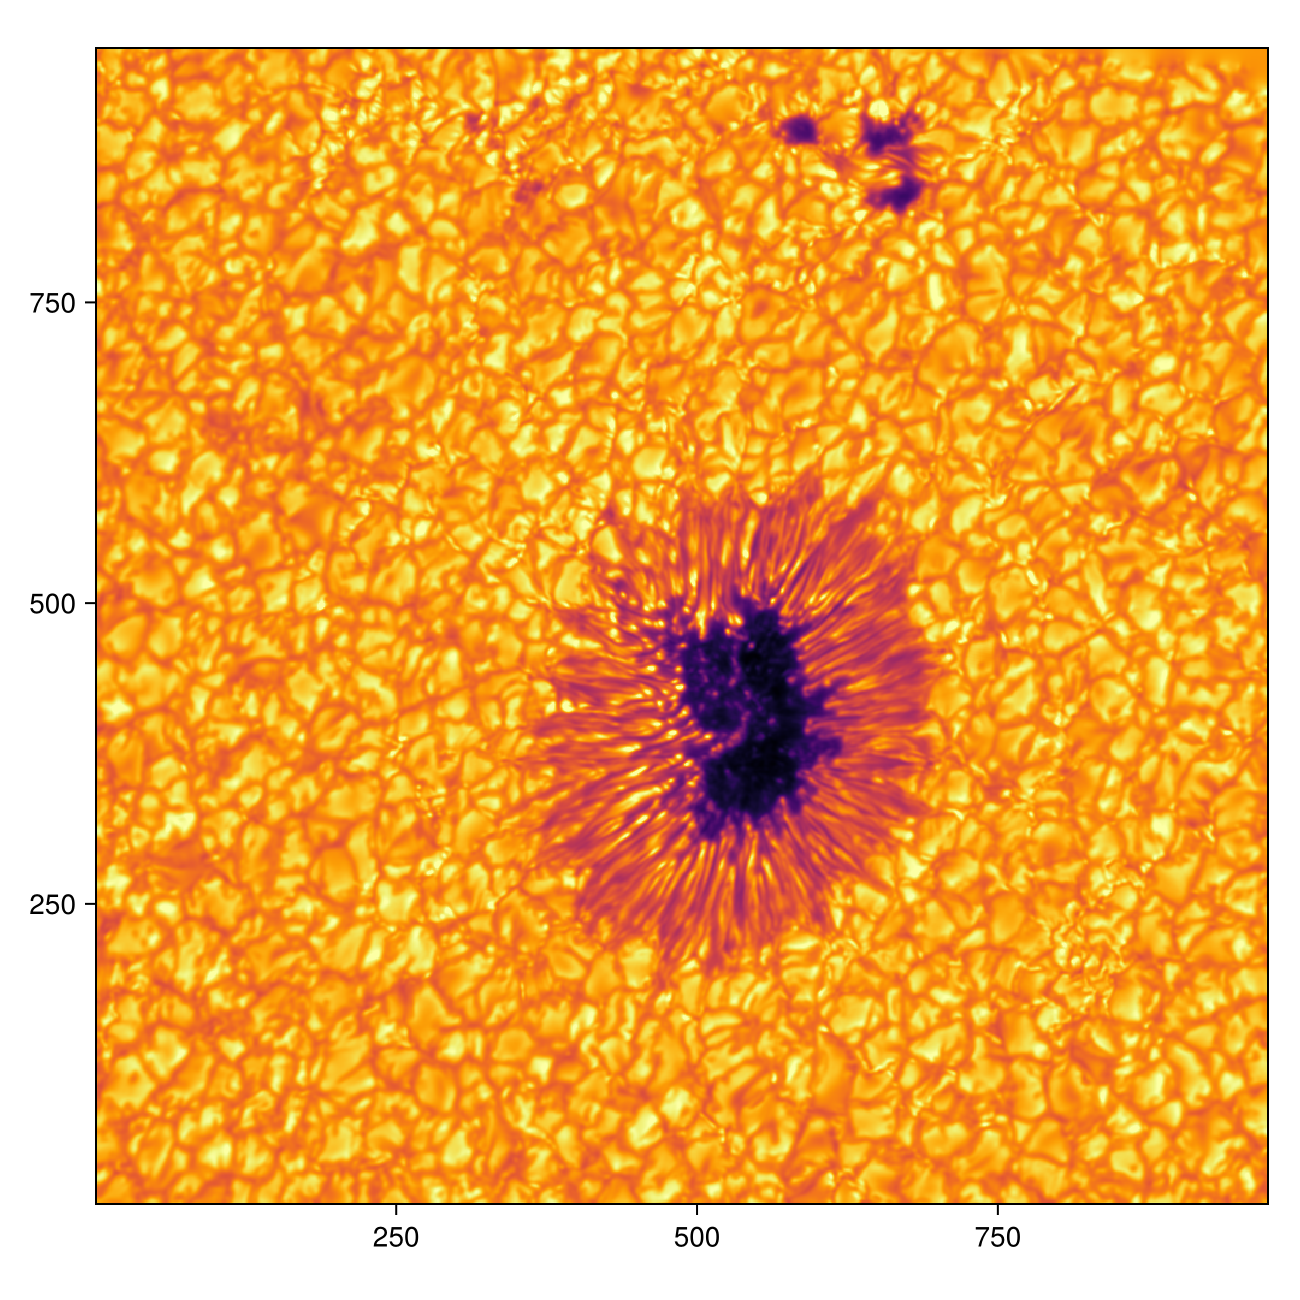

In [12]:
fig = Figure(size=(650,650))
ax = Axis(fig[1,1], aspect=DataAspect())
heatmap!(ax, ustrip(intensity[:, :, 1]), colormap=:inferno, colorrange=(5e-9, 4.6e-8))
fig

We can see the solar granulation pattern, a sign of the the bubbling convection, and a much darker sunspot in the middle. A sunspot has two regions: the dark **umbra**, and the surrounding **penumbra**. In a sunspot the surface convection is inhibited, and therefore it is significantly cooler and darker because not as much radiation is transported to the surface. Near the top of the image there are a few dark spots. They are not sunspots, but pores. They are nearly as dark as the umbra, but show no penumbra. 

We can also see an image of Stokes V. Here at a wavelength with maximum polarisation and with the Oslo colormap, it is very different from the intensity:

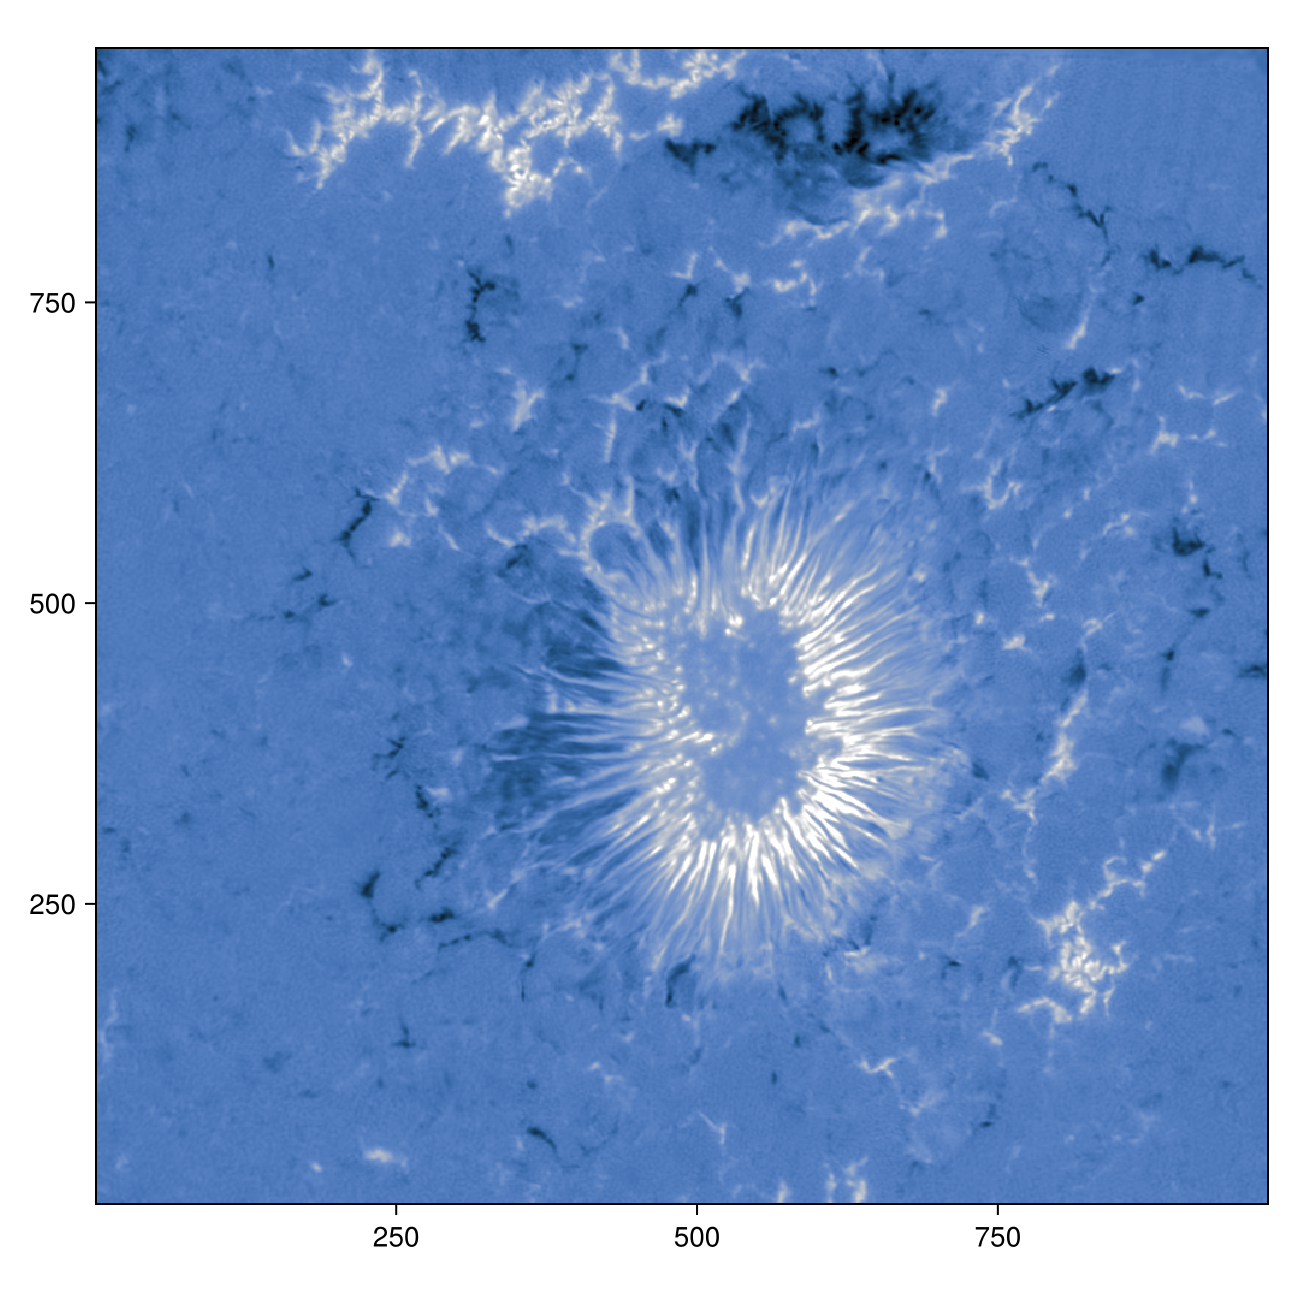

In [13]:
fig = Figure(size=(650,650))
ax = Axis(fig[1,1], aspect=DataAspect())
heatmap!(ax, ustrip(stokes_v[:, :, 5]), colormap=:oslo, colorrange=(-5e-9, 5e-9))
fig

We can also plot individual spectra at specific (x, y) points, for example in the granulation and in the sunspot's umbra:

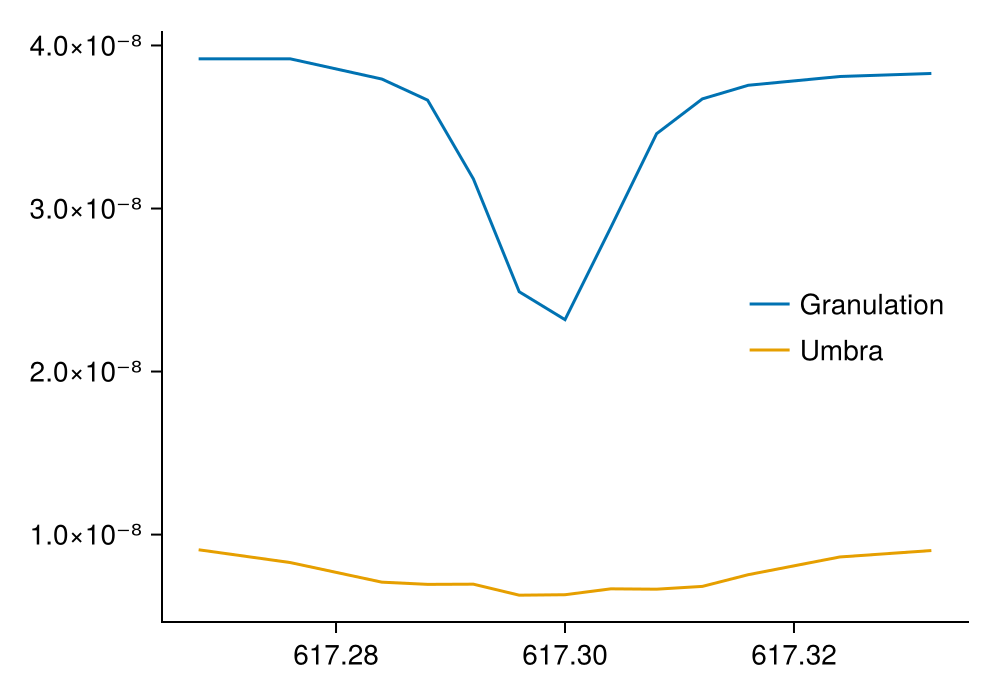

In [14]:
fig = Figure(size=(500,350))
ax = Axis(fig[1,1], xgridvisible=false, ygridvisible=false)
wave = ustrip(wavelength)
lines!(ax, wave, ustrip(intensity[200, 200, :]), label="Granulation")
lines!(ax, wave, ustrip(intensity[550, 400, :]), label="Umbra")
axislegend(ax, position=:rc, framevisible=false)
hidespines!(ax, :t, :r)
fig

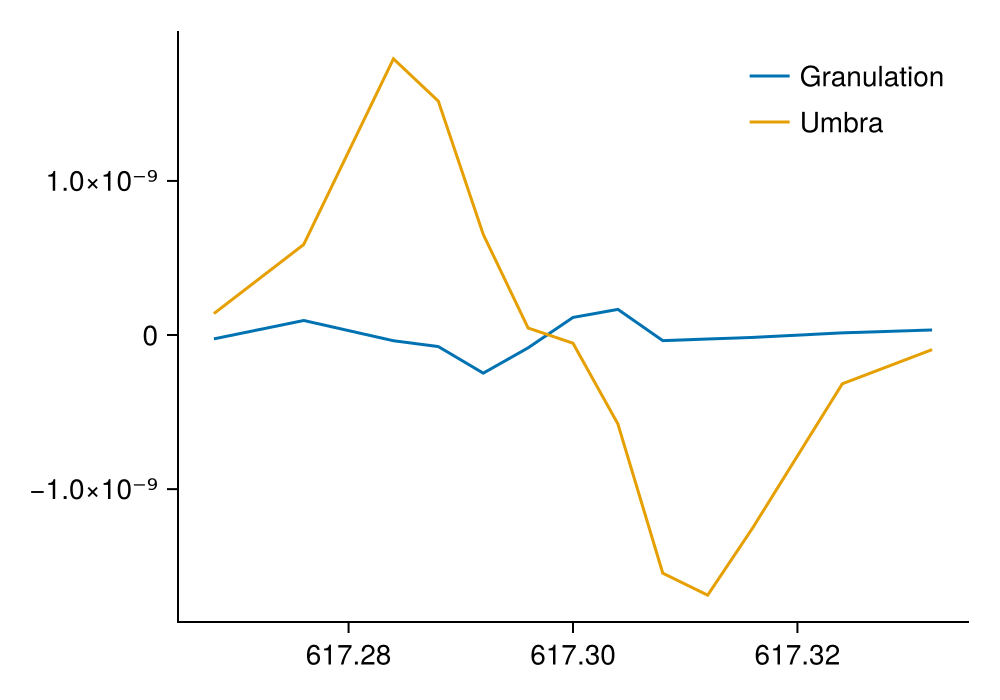

In [15]:
fig = Figure(size=(500,350))
ax = Axis(fig[1,1], xgridvisible=false, ygridvisible=false)
wave = ustrip(wavelength)
lines!(ax, wave, ustrip(stokes_v[200, 200, :]), label="Granulation")
lines!(ax, wave, ustrip(stokes_v[550, 400, :]), label="Umbra")
axislegend(ax, position=:rt, framevisible=false)
hidespines!(ax, :t, :r)
fig

#### 2.5.1 Quick data analysis with spectral moments

To measure properties such as velocities and widths of a line, one option is to fit a function (e.g. a Gaussian is often approximate enough). Since this line is in absorption, you would have to fit an inverted Gaussian, which is cumbersome and numerically unstable. Much better is to instead invert the profiles:

$$
I_\mathrm{inv} = I_0 - I_\lambda,
$$
where $I_0$ is the continuum intensity (e.g. the first or last wavelength).

When we approximate the spectra by a Gaussian, the line-of-sight velocity shift is how much the Gaussian in shifted in the wavelength axis. In other words, it is $\mu$, the mean of the distribution. An even simpler (and faster) option instead of fitting a Gaussian that is also robust in the statistical sense is to take the moments of the distribution (in this case, of the spectra). The first moment $E[X]$ is the mean $\mu$ (i.e., line-of-sight velocity). To take the moments from spectra you need to normalise them, so the expressions become:

$$
E[X] = \mu = \frac{\int \lambda I_\lambda \mathrm{d}\lambda}{\int I_\lambda \mathrm{d}\lambda}
$$

Note that you also need to invert the profiles to take the moments in this way.